In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython import display
import sys
sys.path.append('../lab0')
import maze as mz

In [2]:
# Implemented methods
methods = ['DynProg', 'ValIter'];

# Some colours
LIGHT_RED    = '#FFC4CC';
LIGHT_GREEN  = '#95FD99';
BLACK        = '#000000';
WHITE        = '#FFFFFF';
LIGHT_PURPLE = '#E8D0FF';
LIGHT_ORANGE = '#FAE0C3';

class Maze1:
     # Actions
    STAY       = 0
    MOVE_LEFT  = 1
    MOVE_RIGHT = 2
    MOVE_UP    = 3
    MOVE_DOWN  = 4

    # Give names to actions
    actions_names = {
        STAY: "stay",
        MOVE_LEFT: "move left",
        MOVE_RIGHT: "move right",
        MOVE_UP: "move up",
        MOVE_DOWN: "move down"
    }
    
    def __init__(self, maze, weights=None, STEP_REWARD = 0, GOAL_REWARD = 0, random_rewards=False, min_move=1):
        """ Constructor of the environment Maze.
        """
        self.maze                     = maze;
        self.win_state = self.__win_state()
        self.actions                  = self.__actions();
        self.states, self.map         = self.__states();
        self.n_actions                = len(self.actions);
        self.n_states                 = len(self.states);
        self.min_move = min_move
        self.transition_probabilities = self.__transitions();
        
        self.STEP_REWARD = STEP_REWARD
        self.GOAL_REWARD = GOAL_REWARD
        self.rewards                  = self.__rewards(weights=weights,
                                                random_rewards=random_rewards);
        
        
    def __win_state(self):
        return tuple([i[0] for i in np.where(self.maze == 2)])        
        
    def __actions(self):
        actions = dict();
        actions[self.STAY]       = (0, 0);
        actions[self.MOVE_LEFT]  = (0,-1);
        actions[self.MOVE_RIGHT] = (0, 1);
        actions[self.MOVE_UP]    = (-1,0);
        actions[self.MOVE_DOWN]  = (1,0);
        return actions;
    
    def __states(self):
        states = dict()
        map = dict()
        s = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                if maze[i,j] !=1:
                    for k in range(self.maze.shape[0]):
                        for m in range(self.maze.shape[1]):
                            if maze[k,m] !=1:
                                if ((i,j) != (k,m) and (i,j) != self.win_state):
                                    states[s] = (i,j,k,m)
                                    map[(i,j,k,m)] = s
                                    s += 1

        states[s] = (1,1,1,1) # Win state 
        map[(1,1,1,1)] = s
        s+=1

        states[s] = (-1,-1,-1,-1) #Lost state
        map[(-1,-1,-1,-1)] = s
        return states, map

    def hitting_maze_walls(self,row, col):
        return (row == -1) or (row == self.maze.shape[0]) or \
                  (col == -1) or (col == self.maze.shape[1]) or \
                  (self.maze[row,col] == 1);

    def __moves(self,state,action):
        #If win or loose stay there
        if state == self.map[(-1,-1,-1,-1)] or state == self.map[(1,1,1,1)]:
            return [state]
        s = np.array(self.states[state])
        
        #Check viable moves
        p_next = tuple(s[:2] + self.actions[action])
        if self.hitting_maze_walls(p_next[0], p_next[1]):
                  p_next = tuple(s[:2])
                
        mt_temp = [tuple(s[2:] + self.actions[i]) for i in range(self.min_move,5)]
        mt_next= []
        for mt in mt_temp:
            if not self.hitting_maze_walls(mt[0], mt[1]):
                  mt_next.append(mt)
        
        s_next = [p_next + mt for mt in mt_next]

        #Check if game is finished
        final = []
        for i in s_next:
            if i[:2] == i[2:]:
                final.append((-1,-1,-1,-1))
            elif i[:2] == self.win_state:
                final.append((1,1,1,1))
            else:
                final.append(i)

        if len(final) < 1:
            return [state]
        else:
            return [self.map[i] for i in final]
        
    def __transitions(self):
        dimensions = (self.n_states,self.n_states,self.n_actions)
        transition_probabilities = np.zeros(dimensions)

        for s in range(self.n_states):
            for a in range(self.n_actions):
                next_ss = self.__moves(s,a)
                for next_s in next_ss:
                    transition_probabilities[next_s,s,a] += 1/len(next_ss)

        return transition_probabilities
    
    def __rewards(self, weights=None, random_rewards=None):
        rewards = np.zeros((self.n_states, self.n_actions))
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                next_s = self.__moves(s,a)
                for ns in next_s:
                    if ns == self.n_states-2:
                        rewards[s,a] = self.GOAL_REWARD
                    #elif ns == self.n_states-1:
                    #    rewards[s,a] = -self.GOAL_REWARD
                    else:
                        rewards[s,a] = self.STEP_REWARD
        
        return rewards
    
    def _move(self,state, action):
        next_s = self.__moves(state, action)
        return np.random.choice(next_s)
        
    def simulate(self, start, policy, method='DynProg'):
        if method not in methods:
            error = 'ERROR: the argument method must be in {}'.format(methods);
            raise NameError(error);

        path = list();
        if method == 'DynProg':
            # Deduce the horizon from the policy shape
            horizon = policy.shape[1];
            # Initialize current state and time
            t = 0;
            s = self.map[start];
            # Add the starting position in the maze to the path
            path.append(start);
            while t < horizon-1:
                # Move to next state given the policy and the current state
                next_s = self._move(s,policy[s,t]);
                # Add the position in the maze corresponding to the next state
                # to the path
                path.append(self.states[next_s])
                # Update time and state for next iteration
                t +=1;
                s = next_s;
        
        if method == 'ValIter':
            # Initialize current state, next state and time
            t = 1;
            s = self.map[start];
            # Add the starting position in the maze to the path
            path.append(start);
            # Move to next state given the policy and the current state
            next_s = self._move(s,policy[s]);
            # Add the position in the maze corresponding to the next state
            # to the path
            path.append(self.states[next_s]);
            
            # Loop while state is not the goal or lost state
            while s != self.n_states -1 and s!=self.n_states-2 and t <50 :
                # Update state
                s = next_s;
                # Move to next state given the policy and the current state
                next_s = self._move(s,policy[s]);
                # Add the position in the maze corresponding to the next state
                # to the path
                path.append(self.states[next_s])
                # Update time and state for next iteration
                t +=1;
        
        return path

def dynamic_programming(env, horizon):
    p         = env.transition_probabilities;
    r         = env.rewards;
    n_states  = env.n_states;
    n_actions = env.n_actions;
    T         = horizon;

    # The variables involved in the dynamic programming backwards recursions
    V      = np.zeros((n_states, T+1));
    policy = np.zeros((n_states, T+1));
    Q      = np.zeros((n_states, n_actions));


    # Initialization
    Q            = np.copy(r);
    V[:, T]      = np.max(Q,1);
    policy[:, T] = np.argmax(Q,1);
    V[env.n_states-2, T] = 1
    
    for t in range(T-1,-1,-1):
        # Update the value function acccording to the bellman equation
        for s in range(n_states):
            for a in range(n_actions):
                # Update of the temporary Q values
                Q[s,a] = r[s,a] + np.dot(p[:,s,a],V[:,t+1])
        # Update by taking the maximum Q value w.r.t the action a
        V[:,t] = np.max(Q,1);
        # The optimal action is the one that maximizes the Q function
        policy[:,t] = np.argmax(Q,1);
    
    return V, policy

def value_iteration(env, gamma, epsilon):
    """ Solves the shortest path problem using value iteration
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input float gamma        : The discount factor.
        :input float epsilon      : accuracy of the value iteration procedure.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """
    # The value itearation algorithm requires the knowledge of :
    # - Transition probabilities
    # - Rewards
    # - State space
    # - Action space
    # - The finite horizon
    p         = env.transition_probabilities;
    r         = env.rewards;
    n_states  = env.n_states;
    n_actions = env.n_actions;

    # Required variables and temporary ones for the VI to run
    V   = np.zeros(n_states);
    Q   = np.zeros((n_states, n_actions));
    BV  = np.zeros(n_states);
    # Iteration counter
    n   = 0;
    # Tolerance error
    tol = (1 - gamma)* epsilon/gamma;
    # Initialization of the VI
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = r[s,a] + gamma*np.dot(p[:,s,a],V);
    BV = np.max(Q, 1);
    # Iterate until convergence
    while np.linalg.norm(V - BV) >= tol and n < 200:
        # Increment by one the numbers of iteration
        n += 1;
        # Update the value function
        V = np.copy(BV);
        # Compute the new BV
        for s in range(n_states):
            for a in range(n_actions):
                Q[s, a] = r[s, a] + gamma*np.dot(p[:,s,a],V);
        BV = np.max(Q, 1);
        # Show error
        #print(np.linalg.norm(V - BV))

    # Compute policy
    policy = np.argmax(Q,1);
    # Return the obtained policy
    return V, policy;

def Q_learning(env, gamma, epsilon, n_episodes, n_steps):
    rewards = env.rewards
    start = env.map[(0,0,6,5)]
    n_states = env.n_states
    n_actions = env.n_actions
    V      = np.zeros(n_states);
    policy = np.zeros(n_states);
    Q      = np.random.random((n_states, n_actions));
    n      = np.ones((n_states, n_actions))
    
    initial_value = []
    for episode in range(n_episodes):
        s = start
        initial_value.append(V[s])
        print(f'Episode: {episode}')
        for step in range(n_steps):
            #Choose action epsilon-greedy
            if np.random.uniform(0,1)< epsilon:
                a = np.random.randint(env.n_actions)
            else:
                a = np.argmax(Q[s,:])
            
            R = rewards[s,a]
            s_next = env._move(s,a)
            
            Q[s,a] = Q[s,a] + (1/n[s,a]**(2/3))*(R + gamma*np.max(Q[s_next,:]) - Q[s,a])
            n[s,a] += 1
            s=s_next
            
            
            if s == env.map[(1,1,1,1)] or s == env.map[(1,1,1,1)]:
                #Go to next episode
                break
        V[:] = np.max(Q,1)
        policy = np.argmax(Q,1)
        
    return Q, policy,initial_value

def sarsa(env, alpha, gamma, epsilon, n_episodes, n_steps):
    rewards = env.rewards
    start = env.map[(0,0,6,5)]
    n_states = env.n_states
    n_actions = env.n_actions
    
    V      = np.zeros(n_states);
    policy = np.zeros(n_states);
    Q      = np.random.random((n_states, n_actions));
    n      = np.ones((n_states, n_actions))
    
    initial_value = []
    for episode in range(n_episodes):
        s = start
        #Choose action epsilon-greedy
        if np.random.uniform(0,1)< epsilon:
            a = np.random.randint(env.n_actions)
        else:
            a = np.argmax(Q[s,:])

        initial_value.append(V[s])
        print(f'Episode: {episode}')
        for step in range(n_steps):
            R = rewards[s,a]
            s_next = env._move(s,a)
            
            if np.random.uniform(0,1)< epsilon:
                a_next = np.random.randint(env.n_actions)
            else:
                a_next = np.argmax(Q[s_next,:])
            
            Q[s,a] = Q[s,a] + (1/n[s,a]**(alpha))*(R + gamma*Q[s_next,a_next] - Q[s,a])
            n[s,a] += 1
            
            s=s_next;a=a_next
            if s == env.map[(1,1,1,1)] or s == env.map[(1,1,1,1)]:
                #Go to next episode
                break
        V[:] = np.max(Q,1)
        policy = np.argmax(Q,1)
        
    return Q, policy,initial_value

def animate_solution(maze, path):

    # Map a color to each cell in the maze
    col_map = {0: WHITE, 1: BLACK, 2: LIGHT_GREEN, -6: LIGHT_RED, -1: LIGHT_RED};

    # Size of the maze
    rows,cols = maze.shape;

    # Create figure of the size of the maze
    fig = plt.figure(1, figsize=(cols,rows));

    # Remove the axis ticks and add title title
    ax = plt.gca();
    ax.set_title('Policy simulation');
    ax.set_xticks([]);
    ax.set_yticks([]);

    # Give a color to each cell
    colored_maze = [[col_map[maze[j,i]] for i in range(cols)] for j in range(rows)];

    # Create figure of the size of the maze
    fig = plt.figure(1, figsize=(cols,rows))

    # Create a table to color
    grid = plt.table(cellText=None,
                     cellColours=colored_maze,
                     cellLoc='center',
                     loc=(0,0),
                     edges='closed');

    # Modify the hight and width of the cells in the table
    tc = grid.properties()['children']
    for cell in tc:
        cell.set_height(1.0/rows);
        cell.set_width(1.0/cols);

    
    end = tuple([i[0] for i in np.where(maze == 2)])
    # Update the color at each frame
    over = False
    for i in range(len(path)):
        if (path[i] == (1,1,1,1) or path[i] ==(-1,-1,-1,-1)) and not over:
            over=True
            grid.get_celld()[(path[i-1][:2])].set_facecolor(col_map[maze[path[i-1][:2]]])
            grid.get_celld()[(path[i-1][:2])].get_text().set_text('')
            grid.get_celld()[(path[i-1][2:])].set_facecolor(col_map[maze[path[i-1][2:]]])
            grid.get_celld()[(path[i-1][2:])].get_text().set_text('')
        if not over:
            if i > 0:
                if path[i][:2] != path[i-1][:2]:
                    grid.get_celld()[(path[i-1][:2])].set_facecolor(col_map[maze[path[i-1][:2]]])
                    grid.get_celld()[(path[i-1][:2])].get_text().set_text('')
                if path[i][2:] != path[i-1][2:]:
                    grid.get_celld()[(path[i-1][2:])].set_facecolor(col_map[maze[path[i-1][2:]]])
                    grid.get_celld()[(path[i-1][2:])].get_text().set_text('')
            grid.get_celld()[(path[i][:2])].set_facecolor(LIGHT_ORANGE)
            grid.get_celld()[(path[i][:2])].get_text().set_text('Player')

            grid.get_celld()[(path[i][2:])].set_facecolor(LIGHT_ORANGE)
            grid.get_celld()[(path[i][2:])].get_text().set_text('MT')
        
        else:
            if path[i] == (1,1,1,1):
                grid.get_celld()[(end)].set_facecolor(LIGHT_GREEN)
                grid.get_celld()[(end)].get_text().set_text('Win')
            else:
                grid.get_celld()[(end)].set_facecolor(LIGHT_RED)
                grid.get_celld()[(end)].get_text().set_text('Lost')
            
        display.display(fig)
        display.clear_output(wait=True)
        time.sleep(0.1)
        

In [3]:
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]
])

## Dyn P

In [413]:
env = Maze1(maze, min_move=0)
start = (0,0,6,5)
V, p = dynamic_programming(env, 20)

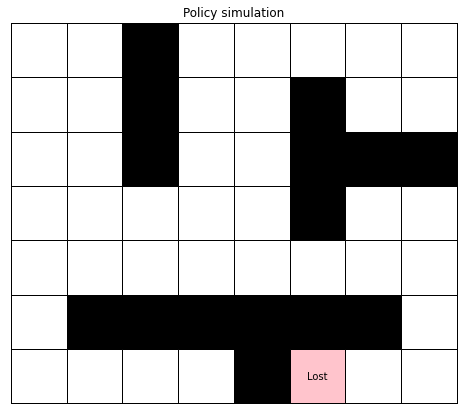

In [418]:
path = env.simulate(start,p,method='DynProg')
animate_solution(maze,path)

In [ ]:
start = (0,0,6,5)
wins,losses = 0,0
win_percentage_dp = []
for t in range(1,31):
    V, p = dynamic_programming(env, t)
    for i in range(int(1e5)):
        path = env.simulate(start,p)
        if path[-1] == (1,1,1,1):
            wins +=1
        else:
            losses +=1
    win_percentage_dp.append(wins/(wins + losses))

In [ ]:
plt.scatter([i for i in range(len(win_percentage_dp))],win_percentage_dp )
plt.title("Win Percentage vs Horizon")
plt.xlabel('Horizon')
plt.ylabel('Percentage')
plt.savefig('dp_win_percentage.png')

## Value Iteration

In [ ]:
# Discount Factor 
gamma   = 29/30; 
# Accuracy treshold 
epsilon = 0.0001;

env = Maze1(maze, STEP_REWARD = -1, GOAL_REWARD = 5, min_move=0)
V, p = value_iteration(env, gamma, epsilon)

In [ ]:
path = env.simulate(start,p,method='ValIter')
animate_solution(maze,path)

In [ ]:
start = (0,0,6,5)
# Discount Factor 
gamma   = 29/30; 
# Accuracy treshold 
epsilon = 0.0001;

wins,losses = 0,0
win_percentage_vi = []
env = Maze1(maze, STEP_REWARD = -1, GOAL_REWARD = 2, min_move=0)
V, p = value_iteration(env, gamma,epsilon)
for t in range(int(1e4)):
    path = env.simulate(start,p,method='ValIter')
    if path[-1] == (1,1,1,1) and len(path) - 1 <= 30:
        wins +=1
    else:
        losses +=1

In [ ]:
wins/(wins + losses)

## Q-Learning

In [ ]:
env = Maze1(maze, STEP_REWARD = 0, GOAL_REWARD = 1, min_move=0)
Q, p, iv = Q_learning(env, gamma, 0.2, 50000, 100)

In [ ]:
plt.plot(iv)

In [ ]:
path = env.simulate(start,p,method='ValIter')
animate_solution(maze,path)

## SARSA

In [20]:
alpha = 2/3
gamma = 29/30
epsilon = 0.2
n_episodes = 50000
n_steps = 100

env = Maze1(maze, STEP_REWARD = 0, GOAL_REWARD = 1, min_move=0)
Q, p, iv = sarsa(env, alpha, gamma,epsilon, n_episodes, n_steps)

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Ep

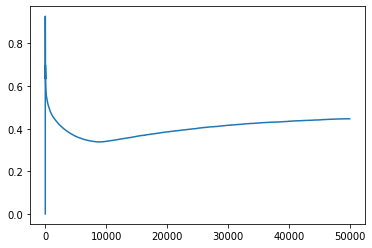

In [21]:
plt.plot(iv)

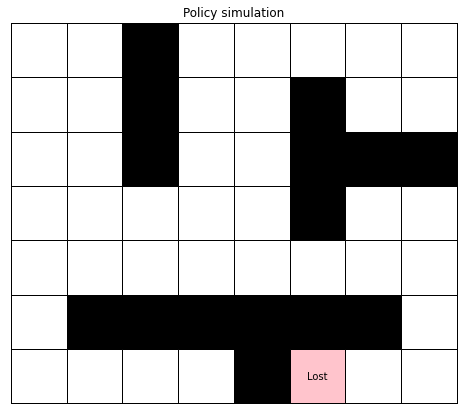

In [22]:
start = (0,0,6,5)
path = env.simulate(start,p,method='ValIter')
animate_solution(maze,path)